In [1]:
import numpy as np
import pandas as pd
np.random.seed(123)

# viz
import matplotlib.pyplot as plt

# notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 1000)

## Sample Prep

In [2]:
samples = pd.read_csv('../data/TCGA/rna-seq_pan/meta/gdc_sample_sheet.2019-12-12.tsv', sep="\t")
# get file type
samples['data'] = [val[1] for i,val in samples['File Name'].str.split(".").items()]
samples.head()

,File ID,File Name,Data Category,Data Type,Project ID,Case ID,Sample ID,Sample Type,data
0,754774dd-77e1-4cf5-b9b5-3afad9f41410,999edb9e-8a45-4115-84d5-fca75dcfa639.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-BRCA,TCGA-E2-A1IG,TCGA-E2-A1IG-01A,Primary Tumor,FPKM
1,8bf102b9-baf7-4749-bcd0-eca25f600722,23393a6a-bfbc-4dec-9ab5-e78a487a095f.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-BRCA,TCGA-EW-A1J5,TCGA-EW-A1J5-01A,Primary Tumor,FPKM
2,5bf7609e-68cb-4ddb-8f05-ee1d4f92cf9b,4a9bb3fd-4e75-4585-82f7-7254889b9838.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-BRCA,TCGA-AR-A1AU,TCGA-AR-A1AU-01A,Primary Tumor,FPKM
3,10a40ceb-080c-4758-97f9-1a262e2639ed,9858d286-1b96-4414-bd09-d73dc6f1c79e.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-LGG,TCGA-DB-A64R,TCGA-DB-A64R-01A,Primary Tumor,FPKM
4,2600ef39-0bdf-4e10-9fdf-e3dbed7b5383,f7182de7-067e-467b-af88-790ad3e63eec.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-LGG,TCGA-P5-A77X,TCGA-P5-A77X-01A,Primary Tumor,FPKM


Samples with RNAseq adjacent normal tissue

In [3]:
samples[samples['Sample Type']=='Solid Tissue Normal']['data'].value_counts()

FPKM    636
Name: data, dtype: int64

In [4]:
samples['project'] = [val[1] for i,val in samples['Project ID'].str.split("-").items()]
samples['project'].value_counts()

BRCA    1206
LUAD     588
UCEC     567
KIRC     554
LUSC     543
LGG      524
PRAD     517
COAD     506
THCA     505
SKCM     469
BLCA     431
LIHC     421
STAD     402
OV       379
KIRP     308
CESC     306
ESCA     171
PAAD     171
GBM      166
TGCT     150
PCPG     133
LAML     123
KICH      81
ACC       75
CHOL      41
SARC      10
DLBC       9
READ       7
MESO       1
Name: project, dtype: int64

In [5]:
# all cases with adjacent normal tissue
cases = samples[samples['Sample Type']=='Solid Tissue Normal']['Case ID']

In [6]:
# disparity in cases
samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Primary Tumor') 
        & (samples['data']=='FPKM') & (samples['project']=='BRCA')]['Case ID'].nunique()
samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Solid Tissue Normal') 
        & (samples['data']=='FPKM') & (samples['project']=='BRCA')]['Case ID'].nunique()

111

112

In [7]:
# divide, join, subset
case_tumor = samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Primary Tumor') & 
                     (samples['data']=='FPKM') & (samples['project']=='BRCA')]
case_norm = samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Solid Tissue Normal') & 
                    (samples['data']=='FPKM') & (samples['project']=='BRCA')]
cases = case_norm[case_norm['Case ID'].isin(case_tumor['Case ID'])]['Case ID']
cases.shape

(111,)

In [8]:
case_tumor = case_tumor[case_tumor['Case ID'].isin(cases)]
case_norm = case_norm[case_norm['Case ID'].isin(cases)]
cases = pd.concat([case_tumor, case_norm])

In [9]:
case_tumor.shape
case_norm.shape
cases.shape

(116, 10)

(111, 10)

(227, 10)

## Dataset Prep

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target = 'Sample Type'
cases[target] = cases[target].astype('category')

train, test = train_test_split(cases)
train[target].value_counts()
test[target].value_counts()

Primary Tumor          90
Solid Tissue Normal    80
Name: Sample Type, dtype: int64

Solid Tissue Normal    31
Primary Tumor          26
Name: Sample Type, dtype: int64

In [11]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
torch.manual_seed(123)

from trainer import fit
import visualization as vis
import numpy as np
cuda = torch.cuda.is_available()
print("Cuda is available: {}".format(cuda))

classes = {key:val for val,key in enumerate(train[target].cat.categories.values)}
classes

Cuda is available: True


{'Primary Tumor': 0, 'Solid Tissue Normal': 1}

In [19]:
from tcga_datasets import TCGA, SiameseTCGA
root_dir = "../data/TCGA/rna-seq_pan/"
batch_size = 1

train_dataset = TCGA(root_dir, samples=train, train=True, target=target, norm=False)
test_dataset = TCGA(root_dir, samples=test, train=False, target=target, norm=False)

scaler = StandardScaler()
train_dataset.data = pd.DataFrame(scaler.fit_transform(train_dataset.data),
                                  index=train_dataset.data.index,
                                  columns=train_dataset.data.columns)
test_dataset.data = pd.DataFrame(scaler.transform(test_dataset.data),
                                 index=test_dataset.data.index,
                                 columns=test_dataset.data.columns)

kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {'num_workers': 10}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

## Siamese Network - Online Pair Selection

In [13]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.labels, n_classes=2, n_samples=5)
test_batch_sampler = BalancedBatchSampler(test_dataset.labels, n_classes=2, n_samples=5)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from tcga_networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 30
log_interval = 5

EmbeddingNet(
  (fc): Sequential(
    (linear1): Linear(in_features=60483, out_features=2000, bias=True)
    (relu1): PReLU(num_parameters=1)
    (linear2): Linear(in_features=2000, out_features=500, bias=True)
    (relu2): PReLU(num_parameters=1)
    (linear3): Linear(in_features=500, out_features=250, bias=True)
    (relu3): PReLU(num_parameters=1)
    (linear4): Linear(in_features=250, out_features=100, bias=True)
    (relu4): PReLU(num_parameters=1)
    (linear5): Linear(in_features=100, out_features=50, bias=True)
    (relu5): PReLU(num_parameters=1)
    (linear6): Linear(in_features=50, out_features=10, bias=True)
    (relu6): PReLU(num_parameters=1)
    (linear7): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [14]:
train_loss, val_loss = fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/170 (0%)]	Loss: 0.497473
Train: [50/170 (29%)]	Loss: 0.467005
Train: [100/170 (59%)]	Loss: 1.767569
Train: [150/170 (88%)]	Loss: 0.292368
Epoch: 1/30. Train set: Average loss: 0.8208
Epoch: 1/30. Validation set: Average loss: 2.8440
Train: [0/170 (0%)]	Loss: 0.805073
Train: [50/170 (29%)]	Loss: 17.410845
Train: [100/170 (59%)]	Loss: 0.365374
Train: [150/170 (88%)]	Loss: 0.399632
Epoch: 2/30. Train set: Average loss: 5.7303
Epoch: 2/30. Validation set: Average loss: 6.9472
Train: [0/170 (0%)]	Loss: 3.696668
Train: [50/170 (29%)]	Loss: 0.669761
Train: [100/170 (59%)]	Loss: 0.553520
Train: [150/170 (88%)]	Loss: 87.283487
Epoch: 3/30. Train set: Average loss: 27.8894
Epoch: 3/30. Validation set: Average loss: 66.2803
Train: [0/170 (0%)]	Loss: 627.737427
Train: [50/170 (29%)]	Loss: 171.791961
Train: [100/170 (59%)]	Loss: 10.897951
Train: [150/170 (88%)]	Loss: 15.480213
Epoch: 4/30. Train set: Average loss: 101.1618
Epoch: 4/30. Validation set: Average loss: 19.8289
Train: [0/170 (

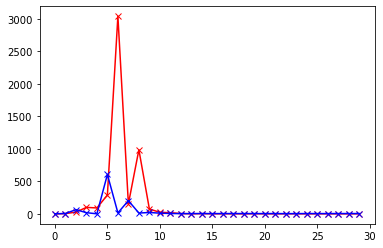

In [15]:
plt.plot(range(0, n_epochs), train_loss, 'rx-')
plt.plot(range(0, n_epochs), val_loss, 'bx-')

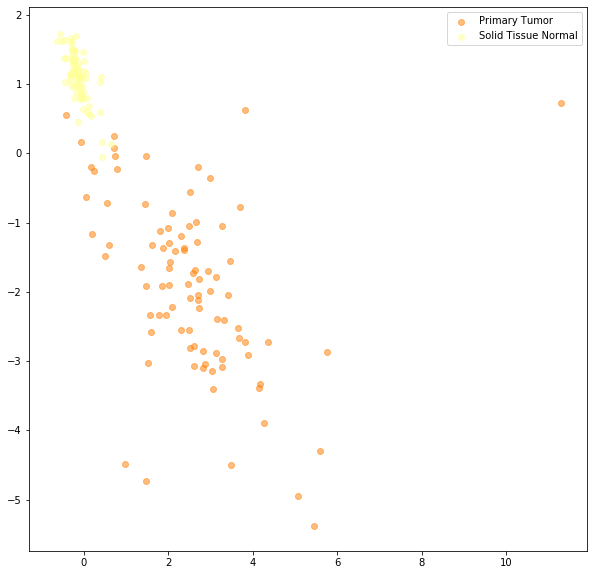

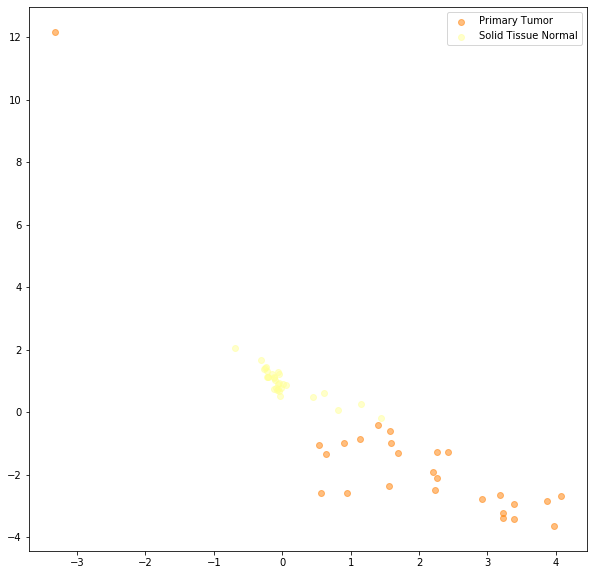

In [20]:
train_embeddings_ocl, train_labels_ocl = vis.extract_embeddings(train_loader, model)
vis.plot_embeddings(train_embeddings_ocl, train_labels_ocl, train_dataset.labels_dict)
val_embeddings_ocl, val_labels_ocl = vis.extract_embeddings(test_loader, model)
vis.plot_embeddings(val_embeddings_ocl, val_labels_ocl, test_dataset.labels_dict)

## Integrated Gradients
Test completeness axiom through comparison of different baselines

"Integrated gradients satisfy an
axiom called completeness that the attributions add up to
the difference between the output of F at the input x and
the baseline x'."

In [34]:
import copy
from captum.attr import LayerActivation
from captum.attr import IntegratedGradients

In [35]:
tmp_model = copy.deepcopy(model)

In [36]:
tmp_model

EmbeddingNet(
  (fc): Sequential(
    (linear1): Linear(in_features=60483, out_features=2000, bias=True)
    (relu1): PReLU(num_parameters=1)
    (linear2): Linear(in_features=2000, out_features=500, bias=True)
    (relu2): PReLU(num_parameters=1)
    (linear3): Linear(in_features=500, out_features=250, bias=True)
    (relu3): PReLU(num_parameters=1)
    (linear4): Linear(in_features=250, out_features=100, bias=True)
    (relu4): PReLU(num_parameters=1)
    (linear5): Linear(in_features=100, out_features=50, bias=True)
    (relu5): PReLU(num_parameters=1)
    (linear6): Linear(in_features=50, out_features=10, bias=True)
    (relu6): PReLU(num_parameters=1)
    (linear7): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [37]:
def attribution_pairs(SiameseTCGA, exp, ctrl):
    # subset different samples
    negative_pairs = np.array(SiameseTCGA.test_pairs)
    negative_pairs = negative_pairs[negative_pairs[:,2] == 0]
    # map labels to integers
    ctrl = siamese_test_dataset.labels_dict[ctrl]
    exp = siamese_test_dataset.labels_dict[exp]
    # ordered indices of samples
    ctrl_data = [idx for pair in negative_pairs[:, :2] for idx in pair if np.isin(idx, SiameseTCGA.label_to_indices[ctrl])]
    exp_data = [idx for pair in negative_pairs[:, :2] for idx in pair if np.isin(idx, SiameseTCGA.label_to_indices[exp])]
    # data
    ctrl_data = Variable(SiameseTCGA.test_data[ctrl_data], requires_grad=True)
    exp_data = Variable(SiameseTCGA.test_data[exp_data], requires_grad=True)
    return ctrl_data, exp_data

### IG with Control vector

In [39]:
siamese_train_dataset = SiameseTCGA(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseTCGA(test_dataset)

In [40]:
ctrl_data, exp_data = attribution_pairs(siamese_test_dataset, exp='Primary Tumor', ctrl='Solid Tissue Normal')

In [41]:
ig = IntegratedGradients(tmp_model.get_embedding)

In [42]:
attr, delta = ig.attribute(exp_data.cuda(), ctrl_data.cuda(), target=0, n_steps=50, return_convergence_delta=True)
attr = attr.cpu().detach().numpy()

(28, 60483)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff00c6a3898>]],
      dtype=object)

,Attribution
count,60483.000000
mean,-0.000004
std,0.000308
min,-0.008740
25%,-0.000012
50%,0.000000
75%,0.000008
max,0.067780


,Attribution
0,
ENSG00000249557.2,0.067780
ENSG00000230014.1,0.021713
ENSG00000273906.1,0.011280
ENSG00000259094.1,0.007718
ENSG00000233070.1,0.005054
ENSG00000092377.12,0.004455
ENSG00000006611.14,0.003599
ENSG00000259154.1,0.003443
ENSG00000255079.1,0.002817


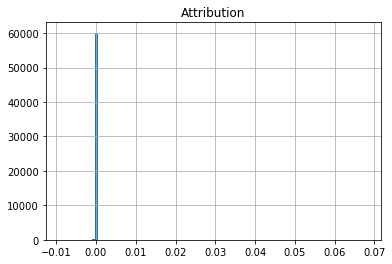

In [43]:
attr.shape
feat_imp = pd.DataFrame(data=attr.mean(axis=0), index=train_dataset.data.columns, columns=['Attribution'])
feat_imp.hist(bins=100)
feat_imp.describe()
feat_imp.nlargest(10, columns='Attribution')

### Test completeness axiom
- Euclidean Distance between samples
- feature attribution sum
- difference between

In [44]:
pdist = torch.nn.PairwiseDistance(p=2)
outdist = pdist(exp_data, ctrl_data)

diff = np.round(outdist.detach().numpy() - attr.sum(axis=1), 3)
diff.mean(); np.median(diff); diff.var()

1543.0095

625.2615

9738813.0

#### Inspect individual sample attributions

In [45]:
for i in range(len(attr)):
    attr_samp = pd.Series(attr[i], index=train_dataset.data.columns)
    attr_samp.nlargest(10)

0
ENSG00000229028.2    0.008716
ENSG00000233304.4    0.006057
ENSG00000187242.4    0.003135
ENSG00000274244.1    0.002256
ENSG00000269621.1    0.002137
ENSG00000225036.1    0.001909
ENSG00000243766.6    0.001559
ENSG00000249343.1    0.001385
ENSG00000253488.1    0.001342
ENSG00000207798.1    0.001222
dtype: float32

0
ENSG00000171004.16    0.005980
ENSG00000264295.1     0.004522
ENSG00000232715.1     0.004191
ENSG00000173898.10    0.003840
ENSG00000223976.1     0.003152
ENSG00000253160.1     0.003100
ENSG00000101977.18    0.002898
ENSG00000223414.2     0.002724
ENSG00000161055.3     0.002675
ENSG00000120211.4     0.002231
dtype: float32

0
ENSG00000232188.1     0.044022
ENSG00000213549.3     0.002822
ENSG00000225538.1     0.002591
ENSG00000216072.2     0.002534
ENSG00000224814.1     0.002459
ENSG00000224718.1     0.002431
ENSG00000107672.13    0.002248
ENSG00000243135.4     0.001776
ENSG00000187840.4     0.001681
ENSG00000253484.1     0.001661
dtype: float32

0
ENSG00000277876.1     0.010136
ENSG00000215943.1     0.009612
ENSG00000229755.1     0.007661
ENSG00000226975.1     0.006939
ENSG00000227537.1     0.005917
ENSG00000254320.1     0.005215
ENSG00000168703.5     0.004891
ENSG00000175121.10    0.004112
ENSG00000257842.4     0.003818
ENSG00000236990.1     0.003707
dtype: float32

0
ENSG00000223716.2     0.036732
ENSG00000131737.5     0.025385
ENSG00000122585.6     0.024183
ENSG00000229310.1     0.020679
ENSG00000054938.14    0.012676
ENSG00000254083.4     0.012120
ENSG00000222236.1     0.009890
ENSG00000169344.14    0.009695
ENSG00000224162.1     0.009417
ENSG00000137673.7     0.009070
dtype: float32

0
ENSG00000273906.1     0.114782
ENSG00000233070.1     0.038237
ENSG00000092377.12    0.030685
ENSG00000143512.11    0.010215
ENSG00000171004.16    0.009698
ENSG00000232715.1     0.009402
ENSG00000260068.1     0.007868
ENSG00000253160.1     0.006790
ENSG00000173898.10    0.006670
ENSG00000244619.2     0.006483
dtype: float32

0
ENSG00000230014.1     0.609203
ENSG00000271307.1     0.031987
ENSG00000251297.1     0.019879
ENSG00000205745.2     0.008078
ENSG00000157087.15    0.007092
ENSG00000255433.4     0.005520
ENSG00000147570.8     0.005107
ENSG00000228695.8     0.004333
ENSG00000264451.1     0.004298
ENSG00000182459.4     0.003870
dtype: float32

0
ENSG00000249557.2    0.891380
ENSG00000256321.4    0.011253
ENSG00000233258.1    0.007737
ENSG00000164089.7    0.007125
ENSG00000261277.2    0.006436
ENSG00000177243.3    0.004771
ENSG00000254926.1    0.004761
ENSG00000236960.1    0.004738
ENSG00000254842.5    0.004567
ENSG00000273857.1    0.004545
dtype: float32

0
ENSG00000231593.1     0.003391
ENSG00000165084.14    0.002447
ENSG00000279359.1     0.001919
ENSG00000216058.1     0.001853
ENSG00000227120.1     0.001459
ENSG00000260568.1     0.001288
ENSG00000270008.1     0.001287
ENSG00000275319.1     0.001199
ENSG00000277212.1     0.001032
ENSG00000253479.4     0.001029
dtype: float32

0
ENSG00000268089.2     0.007629
ENSG00000241244.1     0.005728
ENSG00000276348.1     0.005407
ENSG00000215644.8     0.003938
ENSG00000277683.1     0.003515
ENSG00000227386.1     0.003454
ENSG00000156395.11    0.002781
ENSG00000260573.1     0.002698
ENSG00000280412.1     0.002490
ENSG00000236387.1     0.002372
dtype: float32

0
ENSG00000201923.1    0.005699
ENSG00000249764.1    0.005023
ENSG00000230051.1    0.003092
ENSG00000233944.1    0.002884
ENSG00000278139.1    0.002194
ENSG00000253900.1    0.002158
ENSG00000269791.4    0.002067
ENSG00000162685.6    0.001762
ENSG00000214660.6    0.001692
ENSG00000248611.1    0.001623
dtype: float32

0
ENSG00000006611.14    0.100101
ENSG00000242207.1     0.034194
ENSG00000171551.10    0.020785
ENSG00000229310.1     0.019379
ENSG00000188162.9     0.016471
ENSG00000158764.6     0.016291
ENSG00000112499.11    0.014350
ENSG00000231419.5     0.013426
ENSG00000095713.12    0.013049
ENSG00000141639.10    0.012761
dtype: float32

0
ENSG00000259154.1    0.094665
ENSG00000258991.1    0.050977
ENSG00000274773.1    0.022549
ENSG00000258567.1    0.018802
ENSG00000221747.1    0.017946
ENSG00000215545.1    0.015876
ENSG00000252151.1    0.009471
ENSG00000244302.1    0.009288
ENSG00000277716.1    0.008470
ENSG00000276079.1    0.008468
dtype: float32

0
ENSG00000251454.1     0.011816
ENSG00000255406.1     0.007801
ENSG00000226321.5     0.004232
ENSG00000249343.1     0.003837
ENSG00000184672.10    0.003626
ENSG00000221741.1     0.002984
ENSG00000276899.1     0.002748
ENSG00000272681.2     0.002275
ENSG00000233730.1     0.002137
ENSG00000186710.10    0.001900
dtype: float32

0
ENSG00000273906.1     0.105931
ENSG00000092377.12    0.036787
ENSG00000233070.1     0.023211
ENSG00000253968.1     0.018647
ENSG00000229755.1     0.017405
ENSG00000215943.1     0.016454
ENSG00000226975.1     0.010902
ENSG00000168703.5     0.008761
ENSG00000260068.1     0.007514
ENSG00000229236.1     0.006718
dtype: float32

0
ENSG00000201923.1    0.004316
ENSG00000217089.1    0.003908
ENSG00000249764.1    0.003491
ENSG00000278139.1    0.002746
ENSG00000235845.1    0.002003
ENSG00000224634.1    0.001675
ENSG00000229188.2    0.001657
ENSG00000267168.1    0.001613
ENSG00000244246.1    0.001575
ENSG00000254801.1    0.001374
dtype: float32

0
ENSG00000223648.3    0.034116
ENSG00000268751.1    0.020663
ENSG00000224041.3    0.008186
ENSG00000211664.2    0.007278
ENSG00000211904.2    0.006929
ENSG00000242207.1    0.006820
ENSG00000221793.1    0.005685
ENSG00000252272.1    0.004734
ENSG00000275773.1    0.004435
ENSG00000253555.1    0.004365
dtype: float32

0
ENSG00000253338.1     0.015901
ENSG00000258381.1     0.010146
ENSG00000156222.10    0.006857
ENSG00000280411.1     0.006629
ENSG00000211662.2     0.006481
ENSG00000254645.1     0.004924
ENSG00000226336.2     0.004343
ENSG00000227275.1     0.004214
ENSG00000228131.1     0.003577
ENSG00000260332.1     0.003394
dtype: float32

0
ENSG00000259094.1     0.086896
ENSG00000255079.1     0.031702
ENSG00000235142.6     0.008960
ENSG00000211668.2     0.007889
ENSG00000109208.4     0.007495
ENSG00000211917.1     0.006481
ENSG00000244661.1     0.006017
ENSG00000204889.9     0.005952
ENSG00000223976.1     0.005841
ENSG00000122733.12    0.005743
dtype: float32

0
ENSG00000223716.2     0.037742
ENSG00000122585.6     0.021705
ENSG00000131737.5     0.020752
ENSG00000054938.14    0.012554
ENSG00000254083.4     0.012124
ENSG00000169344.14    0.010142
ENSG00000274167.3     0.008277
ENSG00000137673.7     0.008228
ENSG00000254626.1     0.008177
ENSG00000232480.1     0.008116
dtype: float32

0
ENSG00000242262.1    0.005723
ENSG00000201923.1    0.005472
ENSG00000249764.1    0.004781
ENSG00000253900.1    0.002088
ENSG00000229142.1    0.001996
ENSG00000278139.1    0.001985
ENSG00000229188.2    0.001531
ENSG00000214660.6    0.001369
ENSG00000177243.3    0.001276
ENSG00000200839.1    0.001225
dtype: float32

0
ENSG00000230628.1     0.015542
ENSG00000180424.6     0.010183
ENSG00000223976.1     0.009610
ENSG00000163536.11    0.006114
ENSG00000231674.1     0.003564
ENSG00000221072.1     0.003472
ENSG00000004939.12    0.003446
ENSG00000228044.2     0.003066
ENSG00000264592.2     0.002804
ENSG00000230834.1     0.002738
dtype: float32

0
ENSG00000259094.1     0.128463
ENSG00000255079.1     0.046115
ENSG00000235142.6     0.016159
ENSG00000276899.1     0.014872
ENSG00000211917.1     0.012703
ENSG00000211668.2     0.012064
ENSG00000204889.9     0.009965
ENSG00000215398.10    0.009717
ENSG00000211819.3     0.009702
ENSG00000109208.4     0.009014
dtype: float32

0
ENSG00000249557.2     1.004761
ENSG00000273906.1     0.095513
ENSG00000233070.1     0.080059
ENSG00000092377.12    0.057355
ENSG00000233258.1     0.015442
ENSG00000225537.1     0.013528
ENSG00000256321.4     0.012636
ENSG00000254842.5     0.012610
ENSG00000229236.1     0.012021
ENSG00000260068.1     0.009479
dtype: float32

0
ENSG00000230628.1     0.020873
ENSG00000180424.6     0.013390
ENSG00000163536.11    0.007696
ENSG00000231674.1     0.004645
ENSG00000213417.3     0.004501
ENSG00000228044.2     0.003803
ENSG00000230834.1     0.003480
ENSG00000255259.2     0.003322
ENSG00000264592.2     0.003254
ENSG00000275682.1     0.003235
dtype: float32

0
ENSG00000229755.1     0.011039
ENSG00000215943.1     0.010551
ENSG00000226975.1     0.007517
ENSG00000253968.1     0.006391
ENSG00000168703.5     0.005322
ENSG00000254320.1     0.004538
ENSG00000175121.10    0.004130
ENSG00000236990.1     0.003845
ENSG00000257842.4     0.003656
ENSG00000239810.3     0.003246
dtype: float32

0
ENSG00000251454.1     0.008952
ENSG00000255406.1     0.006716
ENSG00000221741.1     0.005488
ENSG00000226321.5     0.003531
ENSG00000241634.1     0.002388
ENSG00000215560.2     0.002211
ENSG00000184672.10    0.001858
ENSG00000233730.1     0.001824
ENSG00000239189.1     0.001566
ENSG00000248322.1     0.001565
dtype: float32

0
ENSG00000253497.1     0.010679
ENSG00000232216.1     0.009016
ENSG00000259680.5     0.008338
ENSG00000049247.12    0.008050
ENSG00000270685.1     0.007581
ENSG00000211924.1     0.007556
ENSG00000211668.2     0.006342
ENSG00000221287.1     0.006249
ENSG00000253386.1     0.006211
ENSG00000253278.1     0.005606
dtype: float32

In [65]:
for i in range(len(attr)):
    attr_samp = pd.Series(attr[i], index=train_dataset.data.columns)
    attr_samp.nsmallest(10)

0
ENSG00000258115.1   -0.020153
ENSG00000226374.1   -0.013078
ENSG00000233494.1   -0.010390
ENSG00000227425.1   -0.009856
ENSG00000231894.1   -0.009350
ENSG00000275138.1   -0.006200
ENSG00000225036.1   -0.006060
ENSG00000202398.1   -0.005658
ENSG00000234723.1   -0.005407
ENSG00000261595.1   -0.005391
dtype: float32

0
ENSG00000096006.10   -0.051280
ENSG00000226707.1    -0.005662
ENSG00000244619.2    -0.004841
ENSG00000143512.11   -0.004517
ENSG00000221287.1    -0.004366
ENSG00000264295.1    -0.002291
ENSG00000161055.3    -0.002115
ENSG00000182256.11   -0.002097
ENSG00000174080.9    -0.002042
ENSG00000232756.1    -0.001683
dtype: float32

0
ENSG00000232188.1    -0.092254
ENSG00000241635.6    -0.024769
ENSG00000224814.1    -0.022001
ENSG00000172296.11   -0.010962
ENSG00000243135.4    -0.009937
ENSG00000249425.1    -0.009781
ENSG00000224711.1    -0.008233
ENSG00000240584.3    -0.007786
ENSG00000198452.6    -0.006907
ENSG00000224625.2    -0.006817
dtype: float32

0
ENSG00000253968.1   -0.033750
ENSG00000277876.1   -0.005581
ENSG00000234670.1   -0.003152
ENSG00000158480.9   -0.002954
ENSG00000123584.7   -0.002924
ENSG00000275958.1   -0.002655
ENSG00000274028.1   -0.002271
ENSG00000277950.1   -0.002268
ENSG00000156575.2   -0.002252
ENSG00000249513.2   -0.002225
dtype: float32

0
ENSG00000105550.7    -0.056318
ENSG00000111700.11   -0.029090
ENSG00000131737.5    -0.028118
ENSG00000237153.1    -0.014026
ENSG00000255271.1    -0.013234
ENSG00000222236.1    -0.011507
ENSG00000254925.1    -0.010706
ENSG00000240611.1    -0.009435
ENSG00000126550.7    -0.009384
ENSG00000253275.1    -0.009023
dtype: float32

0
ENSG00000233070.1    -0.266600
ENSG00000229308.1    -0.148068
ENSG00000092377.12   -0.133492
ENSG00000229236.1    -0.047350
ENSG00000235343.1    -0.044474
ENSG00000231535.4    -0.032928
ENSG00000226863.1    -0.029697
ENSG00000176728.6    -0.029500
ENSG00000237659.1    -0.028955
ENSG00000227447.1    -0.025504
dtype: float32

0
ENSG00000162621.6    -0.032625
ENSG00000251297.1    -0.026464
ENSG00000125895.5    -0.017651
ENSG00000205745.2    -0.013172
ENSG00000261078.1    -0.012770
ENSG00000142609.16   -0.012247
ENSG00000201095.1    -0.012151
ENSG00000151458.10   -0.011269
ENSG00000164125.14   -0.010430
ENSG00000279139.1    -0.009406
dtype: float32

0
ENSG00000230720.1    -0.029059
ENSG00000256321.4    -0.026554
ENSG00000115934.11   -0.026180
ENSG00000263734.1    -0.023048
ENSG00000238819.1    -0.021945
ENSG00000219784.2    -0.017871
ENSG00000186925.6    -0.017144
ENSG00000213747.2    -0.015925
ENSG00000181325.7    -0.015565
ENSG00000223360.1    -0.015178
dtype: float32

0
ENSG00000230418.2   -0.003982
ENSG00000253501.1   -0.002726
ENSG00000232749.2   -0.002087
ENSG00000235976.2   -0.001952
ENSG00000223629.1   -0.001886
ENSG00000278757.1   -0.001576
ENSG00000201095.1   -0.001335
ENSG00000241392.3   -0.001320
ENSG00000270912.1   -0.001293
ENSG00000267251.2   -0.001274
dtype: float32

0
ENSG00000280614.1   -0.200490
ENSG00000258417.3   -0.172212
ENSG00000272558.1   -0.047141
ENSG00000202144.1   -0.027055
ENSG00000241457.1   -0.022308
ENSG00000271220.1   -0.015240
ENSG00000223691.1   -0.012740
ENSG00000186925.6   -0.012453
ENSG00000186970.4   -0.012291
ENSG00000234270.1   -0.010622
dtype: float32

0
ENSG00000203972.8    -0.009966
ENSG00000258567.1    -0.005098
ENSG00000231583.1    -0.004437
ENSG00000236190.1    -0.004403
ENSG00000182070.4    -0.004093
ENSG00000258383.1    -0.003919
ENSG00000171487.13   -0.003812
ENSG00000079156.15   -0.003803
ENSG00000237850.6    -0.003775
ENSG00000207758.1    -0.003648
dtype: float32

0
ENSG00000163283.6    -0.059504
ENSG00000110680.11   -0.050913
ENSG00000242207.1    -0.040723
ENSG00000158764.6    -0.035041
ENSG00000222236.1    -0.021002
ENSG00000150201.13   -0.019247
ENSG00000188162.9    -0.016482
ENSG00000254925.1    -0.015446
ENSG00000253275.1    -0.013005
ENSG00000142549.9    -0.012827
dtype: float32

0
ENSG00000259154.1   -0.088255
ENSG00000221134.1   -0.053648
ENSG00000223291.1   -0.032669
ENSG00000243715.1   -0.032111
ENSG00000276695.1   -0.028238
ENSG00000243799.1   -0.020042
ENSG00000238051.1   -0.017854
ENSG00000202498.1   -0.017320
ENSG00000198982.3   -0.016304
ENSG00000231411.1   -0.016038
dtype: float32

0
ENSG00000224920.1   -0.011113
ENSG00000241634.1   -0.010374
ENSG00000265015.1   -0.008740
ENSG00000236012.2   -0.002961
ENSG00000277515.1   -0.002750
ENSG00000203685.8   -0.002603
ENSG00000238764.1   -0.002569
ENSG00000200572.1   -0.002302
ENSG00000162685.6   -0.002178
ENSG00000275411.1   -0.002175
dtype: float32

0
ENSG00000233070.1    -0.171068
ENSG00000253968.1    -0.109962
ENSG00000229308.1    -0.108614
ENSG00000092377.12   -0.085090
ENSG00000229236.1    -0.036187
ENSG00000231535.4    -0.026883
ENSG00000226863.1    -0.026653
ENSG00000227447.1    -0.020328
ENSG00000237659.1    -0.019410
ENSG00000176728.6    -0.019255
dtype: float32

0
ENSG00000263566.1   -0.011253
ENSG00000268711.1   -0.008998
ENSG00000201923.1   -0.005751
ENSG00000264030.2   -0.005312
ENSG00000207101.1   -0.005304
ENSG00000229142.1   -0.003694
ENSG00000243669.2   -0.003564
ENSG00000260289.1   -0.003535
ENSG00000270242.1   -0.003142
ENSG00000258970.1   -0.002992
dtype: float32

0
ENSG00000256709.2   -0.014481
ENSG00000233970.1   -0.010687
ENSG00000223648.3   -0.009072
ENSG00000253555.1   -0.005365
ENSG00000253901.1   -0.005109
ENSG00000267012.1   -0.005061
ENSG00000267489.2   -0.004894
ENSG00000267664.1   -0.004335
ENSG00000229769.2   -0.004297
ENSG00000217707.2   -0.004172
dtype: float32

0
ENSG00000254407.1   -0.033035
ENSG00000225036.1   -0.019394
ENSG00000237197.1   -0.011764
ENSG00000276366.1   -0.011574
ENSG00000257691.2   -0.010197
ENSG00000257935.2   -0.009377
ENSG00000227244.2   -0.008596
ENSG00000239320.1   -0.008568
ENSG00000211911.1   -0.008223
ENSG00000205835.7   -0.006802
dtype: float32

0
ENSG00000259094.1    -0.103273
ENSG00000254220.1    -0.011670
ENSG00000225036.1    -0.008860
ENSG00000231586.2    -0.008588
ENSG00000197273.3    -0.008558
ENSG00000264108.1    -0.008401
ENSG00000230973.1    -0.008185
ENSG00000260476.1    -0.007725
ENSG00000275138.1    -0.007546
ENSG00000177504.10   -0.007539
dtype: float32

0
ENSG00000105550.7    -0.020872
ENSG00000223716.2    -0.008421
ENSG00000255271.1    -0.007215
ENSG00000237153.1    -0.006637
ENSG00000111700.11   -0.006185
ENSG00000274694.1    -0.003645
ENSG00000188581.8    -0.003498
ENSG00000263590.2    -0.003149
ENSG00000233085.4    -0.003117
ENSG00000272456.1    -0.002722
dtype: float32

0
ENSG00000230720.1   -0.005916
ENSG00000181325.7   -0.002325
ENSG00000263734.1   -0.002252
ENSG00000201923.1   -0.002179
ENSG00000258071.1   -0.002072
ENSG00000213747.2   -0.002022
ENSG00000233031.1   -0.001954
ENSG00000186925.6   -0.001917
ENSG00000265470.1   -0.001779
ENSG00000232735.2   -0.001748
dtype: float32

0
ENSG00000255808.1   -0.006321
ENSG00000261595.1   -0.003954
ENSG00000162747.8   -0.003912
ENSG00000225487.2   -0.003196
ENSG00000163736.3   -0.002973
ENSG00000248601.1   -0.002787
ENSG00000137509.9   -0.002443
ENSG00000233208.4   -0.002324
ENSG00000230395.1   -0.002282
ENSG00000244734.2   -0.002263
dtype: float32

0
ENSG00000259094.1    -0.171955
ENSG00000254220.1    -0.014480
ENSG00000231586.2    -0.012123
ENSG00000177504.10   -0.010345
ENSG00000260476.1    -0.009727
ENSG00000255451.1    -0.009244
ENSG00000105550.7    -0.009006
ENSG00000206532.2    -0.008273
ENSG00000261730.1    -0.007937
ENSG00000207130.1    -0.007663
dtype: float32

0
ENSG00000233070.1    -0.366013
ENSG00000229308.1    -0.219602
ENSG00000092377.12   -0.158247
ENSG00000229236.1    -0.067629
ENSG00000231535.4    -0.052304
ENSG00000226863.1    -0.049059
ENSG00000176728.6    -0.042152
ENSG00000227447.1    -0.040918
ENSG00000237659.1    -0.040180
ENSG00000236656.1    -0.025795
dtype: float32

0
ENSG00000255808.1   -0.008290
ENSG00000263590.2   -0.005007
ENSG00000261595.1   -0.003753
ENSG00000225487.2   -0.003371
ENSG00000229063.2   -0.003300
ENSG00000248601.1   -0.002922
ENSG00000233208.4   -0.002368
ENSG00000230395.1   -0.002258
ENSG00000137509.9   -0.002142
ENSG00000232090.2   -0.002137
dtype: float32

0
ENSG00000253968.1   -0.042701
ENSG00000256338.2   -0.009732
ENSG00000199219.1   -0.007270
ENSG00000253359.1   -0.003922
ENSG00000275958.1   -0.003597
ENSG00000158480.9   -0.003054
ENSG00000241392.3   -0.003042
ENSG00000107447.6   -0.002844
ENSG00000273956.1   -0.002778
ENSG00000200443.1   -0.002758
dtype: float32

0
ENSG00000224920.1   -0.011929
ENSG00000241634.1   -0.008382
ENSG00000265015.1   -0.007199
ENSG00000272664.1   -0.005561
ENSG00000275067.1   -0.002492
ENSG00000203685.8   -0.002416
ENSG00000236012.2   -0.002389
ENSG00000238764.1   -0.002380
ENSG00000239189.1   -0.001986
ENSG00000237400.1   -0.001841
dtype: float32

0
ENSG00000279847.2   -0.108686
ENSG00000249818.1   -0.029505
ENSG00000253386.1   -0.025451
ENSG00000224634.1   -0.019634
ENSG00000224638.1   -0.014485
ENSG00000276431.1   -0.013547
ENSG00000235951.1   -0.012901
ENSG00000237197.1   -0.012301
ENSG00000175841.8   -0.010741
ENSG00000276953.1   -0.010610
dtype: float32

#### Check embedding of zero-feature vector

In [46]:
base_zero = torch.zeros(siamese_test_dataset.test_data.shape[1]).cuda()
base_emb = model.get_embedding(base_zero)
base_emb

tensor([-0.1310, -0.1545], device='cuda:0', grad_fn=<AddBackward0>)

#### Check loss of baseline vectors
- control data
- zero vector
- random values

In [47]:
target = torch.tensor(0, dtype=float)
model.get_loss(ctrl_data.cuda(), exp_data.cuda(), target, ContrastiveLoss(margin))

AttributeError: 'EmbeddingNet' object has no attribute 'get_loss'

In [57]:
base_zero = torch.zeros(exp_data.shape).cuda()
model.get_loss(base_zero, exp_data.cuda(), target, ContrastiveLoss(margin))

tensor(0.1132, device='cuda:0', grad_fn=<MeanBackward0>)

In [58]:
rand_base = torch.rand_like(exp_data).cuda()
model.get_loss(rand_base, exp_data.cuda(), target, ContrastiveLoss(margin))

tensor(0.1832, device='cuda:0', grad_fn=<MeanBackward0>)

### IG with zero-feature vector

In [48]:
attr, delta = ig.attribute(exp_data.cuda(), target=0, n_steps=50, return_convergence_delta=True)
attr = attr.cpu().detach().numpy()

(28, 60483)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff19c8c3240>]],
      dtype=object)

,Attribution
count,60483.000000
mean,-0.000002
std,0.000261
min,-0.006819
25%,-0.000011
50%,-0.000002
75%,0.000005
max,0.059499


,Attribution
0,
ENSG00000249557.2,0.059499
ENSG00000230014.1,0.017374
ENSG00000259094.1,0.006563
ENSG00000232188.1,0.002411
ENSG00000255079.1,0.002313
ENSG00000259154.1,0.002009
ENSG00000235142.6,0.001847
ENSG00000229755.1,0.001445
ENSG00000230628.1,0.001371


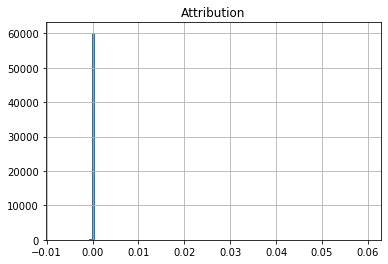

In [49]:
attr.shape
feat_imp = pd.DataFrame(data=attr.mean(axis=0), index=train_dataset.data.columns, columns=['Attribution'])
feat_imp.hist(bins=100)
feat_imp.describe()
feat_imp.nlargest(10, columns='Attribution')

In [50]:
pdist = torch.nn.PairwiseDistance(p=2)
outdist = pdist(exp_data, ctrl_data)

diff = np.round(outdist.detach().numpy() - attr.sum(axis=1), 3)
diff.mean(); np.median(diff); diff.var()

1542.9065

625.08496

9738775.0

In [51]:
for i in range(len(attr)):
    attr_samp = pd.Series(attr[i], index=train_dataset.data.columns)
    attr_samp.nlargest(10)

0
ENSG00000229028.2    0.007742
ENSG00000233304.4    0.005459
ENSG00000187242.4    0.004715
ENSG00000226374.1    0.002481
ENSG00000269621.1    0.002021
ENSG00000253488.1    0.001940
ENSG00000243766.6    0.001859
ENSG00000274244.1    0.001540
ENSG00000248738.5    0.001518
ENSG00000229943.1    0.001292
dtype: float32

0
ENSG00000171004.16    0.007936
ENSG00000232715.1     0.006842
ENSG00000143512.11    0.006603
ENSG00000253160.1     0.004672
ENSG00000244619.2     0.004284
ENSG00000101977.18    0.004160
ENSG00000223414.2     0.004148
ENSG00000188997.6     0.004082
ENSG00000161055.3     0.003237
ENSG00000120211.4     0.003002
dtype: float32

0
ENSG00000232188.1     0.069396
ENSG00000224814.1     0.004946
ENSG00000227802.1     0.003053
ENSG00000178836.6     0.002312
ENSG00000274246.1     0.002022
ENSG00000243135.4     0.001989
ENSG00000167165.17    0.001695
ENSG00000228445.1     0.001604
ENSG00000250997.1     0.001597
ENSG00000224718.1     0.001521
dtype: float32

0
ENSG00000229755.1     0.013539
ENSG00000215943.1     0.010787
ENSG00000253968.1     0.008197
ENSG00000226975.1     0.008053
ENSG00000254320.1     0.005056
ENSG00000168703.5     0.004809
ENSG00000257842.4     0.003833
ENSG00000244067.2     0.003657
ENSG00000239810.3     0.003391
ENSG00000175121.10    0.003220
dtype: float32

0
ENSG00000131737.5     0.011485
ENSG00000223716.2     0.011147
ENSG00000122585.6     0.011040
ENSG00000254083.4     0.003580
ENSG00000054938.14    0.003525
ENSG00000274167.3     0.003213
ENSG00000137673.7     0.002694
ENSG00000205293.3     0.002487
ENSG00000116031.8     0.002450
ENSG00000224865.6     0.002449
dtype: float32

0
ENSG00000171004.16    0.007936
ENSG00000232715.1     0.006842
ENSG00000143512.11    0.006603
ENSG00000253160.1     0.004672
ENSG00000244619.2     0.004284
ENSG00000101977.18    0.004160
ENSG00000223414.2     0.004148
ENSG00000188997.6     0.004082
ENSG00000161055.3     0.003237
ENSG00000120211.4     0.003002
dtype: float32

0
ENSG00000230014.1     0.486664
ENSG00000271307.1     0.035579
ENSG00000251297.1     0.015898
ENSG00000205745.2     0.007241
ENSG00000157087.15    0.006582
ENSG00000147570.8     0.006054
ENSG00000264451.1     0.004236
ENSG00000228695.8     0.003613
ENSG00000255433.4     0.003605
ENSG00000142609.16    0.003100
dtype: float32

0
ENSG00000249557.2    0.833154
ENSG00000256321.4    0.012358
ENSG00000233258.1    0.008863
ENSG00000164089.7    0.007000
ENSG00000261277.2    0.005485
ENSG00000254926.1    0.005451
ENSG00000212899.2    0.005109
ENSG00000254842.5    0.004706
ENSG00000236960.1    0.004549
ENSG00000258712.2    0.003662
dtype: float32

0
ENSG00000236303.2    0.002190
ENSG00000275508.1    0.002016
ENSG00000116031.8    0.001513
ENSG00000253479.4    0.001503
ENSG00000255361.1    0.001259
ENSG00000273561.1    0.001061
ENSG00000239389.6    0.001047
ENSG00000253130.1    0.001014
ENSG00000271894.1    0.000979
ENSG00000279359.1    0.000965
dtype: float32

0
ENSG00000258417.3    0.007781
ENSG00000241244.1    0.003457
ENSG00000276348.1    0.002602
ENSG00000280412.1    0.001684
ENSG00000225724.1    0.001639
ENSG00000227386.1    0.001532
ENSG00000234270.1    0.001490
ENSG00000271220.1    0.001351
ENSG00000260573.1    0.001349
ENSG00000277683.1    0.001083
dtype: float32

0
ENSG00000201923.1    0.004846
ENSG00000249764.1    0.003406
ENSG00000278139.1    0.001968
ENSG00000229142.1    0.001525
ENSG00000253900.1    0.001361
ENSG00000200839.1    0.001283
ENSG00000280493.1    0.001189
ENSG00000229188.2    0.001185
ENSG00000214660.6    0.000910
ENSG00000225870.1    0.000847
dtype: float32

0
ENSG00000006611.14    0.022653
ENSG00000242207.1     0.012059
ENSG00000112499.11    0.005503
ENSG00000188162.9     0.005194
ENSG00000123838.9     0.004579
ENSG00000163283.6     0.004113
ENSG00000163295.4     0.004029
ENSG00000187533.12    0.003965
ENSG00000158764.6     0.003920
ENSG00000141639.10    0.003799
dtype: float32

0
ENSG00000259154.1    0.055387
ENSG00000258991.1    0.033489
ENSG00000215545.1    0.015089
ENSG00000277716.1    0.014008
ENSG00000276079.1    0.012068
ENSG00000258567.1    0.011903
ENSG00000273534.1    0.010026
ENSG00000244302.1    0.009605
ENSG00000252151.1    0.008103
ENSG00000233040.2    0.006155
dtype: float32

0
ENSG00000224920.1     0.004801
ENSG00000184672.10    0.004348
ENSG00000255406.1     0.003629
ENSG00000221741.1     0.002252
ENSG00000226321.5     0.001560
ENSG00000241634.1     0.001375
ENSG00000258271.1     0.001239
ENSG00000267324.1     0.001201
ENSG00000186710.10    0.000952
ENSG00000232480.1     0.000947
dtype: float32

0
ENSG00000229755.1     0.013539
ENSG00000215943.1     0.010787
ENSG00000253968.1     0.008197
ENSG00000226975.1     0.008053
ENSG00000254320.1     0.005056
ENSG00000168703.5     0.004809
ENSG00000257842.4     0.003833
ENSG00000244067.2     0.003657
ENSG00000239810.3     0.003391
ENSG00000175121.10    0.003220
dtype: float32

0
ENSG00000201923.1    0.004846
ENSG00000249764.1    0.003406
ENSG00000278139.1    0.001968
ENSG00000229142.1    0.001525
ENSG00000253900.1    0.001361
ENSG00000200839.1    0.001283
ENSG00000280493.1    0.001189
ENSG00000229188.2    0.001185
ENSG00000214660.6    0.000910
ENSG00000225870.1    0.000847
dtype: float32

0
ENSG00000268751.1    0.021256
ENSG00000223648.3    0.019481
ENSG00000242207.1    0.010176
ENSG00000224041.3    0.009564
ENSG00000278982.1    0.008941
ENSG00000211904.2    0.007553
ENSG00000211662.2    0.006675
ENSG00000256709.2    0.005783
ENSG00000221793.1    0.005571
ENSG00000210741.1    0.005556
dtype: float32

0
ENSG00000253338.1     0.005197
ENSG00000258381.1     0.004658
ENSG00000227244.2     0.003724
ENSG00000156222.10    0.003146
ENSG00000254645.1     0.002793
ENSG00000226336.2     0.002279
ENSG00000255344.1     0.001816
ENSG00000117148.7     0.001796
ENSG00000227275.1     0.001736
ENSG00000228131.1     0.001600
dtype: float32

0
ENSG00000259094.1     0.091820
ENSG00000255079.1     0.032552
ENSG00000235142.6     0.025864
ENSG00000211917.1     0.015383
ENSG00000231586.2     0.012370
ENSG00000204889.9     0.011177
ENSG00000211819.3     0.010977
ENSG00000215398.10    0.010558
ENSG00000248538.5     0.009916
ENSG00000253862.1     0.009511
dtype: float32

0
ENSG00000131737.5     0.011485
ENSG00000223716.2     0.011147
ENSG00000122585.6     0.011040
ENSG00000254083.4     0.003580
ENSG00000054938.14    0.003525
ENSG00000274167.3     0.003213
ENSG00000137673.7     0.002694
ENSG00000205293.3     0.002487
ENSG00000116031.8     0.002450
ENSG00000224865.6     0.002449
dtype: float32

0
ENSG00000201923.1    0.004846
ENSG00000249764.1    0.003406
ENSG00000278139.1    0.001968
ENSG00000229142.1    0.001525
ENSG00000253900.1    0.001361
ENSG00000200839.1    0.001283
ENSG00000280493.1    0.001189
ENSG00000229188.2    0.001185
ENSG00000214660.6    0.000910
ENSG00000225870.1    0.000847
dtype: float32

0
ENSG00000230628.1     0.019291
ENSG00000180424.6     0.011041
ENSG00000163536.11    0.006732
ENSG00000231674.1     0.004746
ENSG00000255259.2     0.003437
ENSG00000165490.11    0.003157
ENSG00000230834.1     0.002975
ENSG00000228044.2     0.002661
ENSG00000275293.1     0.002388
ENSG00000274306.1     0.002291
dtype: float32

0
ENSG00000259094.1     0.091820
ENSG00000255079.1     0.032552
ENSG00000235142.6     0.025864
ENSG00000211917.1     0.015383
ENSG00000231586.2     0.012370
ENSG00000204889.9     0.011177
ENSG00000211819.3     0.010977
ENSG00000215398.10    0.010558
ENSG00000248538.5     0.009916
ENSG00000253862.1     0.009511
dtype: float32

0
ENSG00000249557.2    0.833154
ENSG00000256321.4    0.012358
ENSG00000233258.1    0.008863
ENSG00000164089.7    0.007000
ENSG00000261277.2    0.005485
ENSG00000254926.1    0.005451
ENSG00000212899.2    0.005109
ENSG00000254842.5    0.004706
ENSG00000236960.1    0.004549
ENSG00000258712.2    0.003662
dtype: float32

0
ENSG00000230628.1     0.019291
ENSG00000180424.6     0.011041
ENSG00000163536.11    0.006732
ENSG00000231674.1     0.004746
ENSG00000255259.2     0.003437
ENSG00000165490.11    0.003157
ENSG00000230834.1     0.002975
ENSG00000228044.2     0.002661
ENSG00000275293.1     0.002388
ENSG00000274306.1     0.002291
dtype: float32

0
ENSG00000229755.1     0.013539
ENSG00000215943.1     0.010787
ENSG00000253968.1     0.008197
ENSG00000226975.1     0.008053
ENSG00000254320.1     0.005056
ENSG00000168703.5     0.004809
ENSG00000257842.4     0.003833
ENSG00000244067.2     0.003657
ENSG00000239810.3     0.003391
ENSG00000175121.10    0.003220
dtype: float32

0
ENSG00000224920.1     0.004801
ENSG00000184672.10    0.004348
ENSG00000255406.1     0.003629
ENSG00000221741.1     0.002252
ENSG00000226321.5     0.001560
ENSG00000241634.1     0.001375
ENSG00000258271.1     0.001239
ENSG00000267324.1     0.001201
ENSG00000186710.10    0.000952
ENSG00000232480.1     0.000947
dtype: float32

0
ENSG00000253497.1     0.012719
ENSG00000049247.12    0.010849
ENSG00000211924.1     0.009958
ENSG00000259680.5     0.009766
ENSG00000270685.1     0.009671
ENSG00000232216.1     0.009518
ENSG00000211668.2     0.007633
ENSG00000253386.1     0.007263
ENSG00000253278.1     0.006681
ENSG00000211951.2     0.006658
dtype: float32